# 初始準備
### Keras 可以用不同的深度學習套件當層，為了確保執行的一致性，在此指定用 Tensorflow

In [1]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, IntSlider

## 1. 讀入建立神經網路用到的 keras 相關函數

In [3]:
# NN-related
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adam

# dataset
from keras.datasets import mnist


from keras.utils import to_categorical

C:\Users\Andygyr\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2. 讀入 MNIST 數據庫
### 2.1 由 Keras 讀入
#### 標準手段

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

#### 養成好習慣，沒事就看看資料的長相

In [5]:
print('共有 %d 筆訓練資料，每筆資料尺寸為 %d x %d' %x_train0.shape)

共有 60000 筆訓練資料，每筆資料尺寸為 28 x 28


In [6]:
x_train0.shape

(60000, 28, 28)

## 2.2 輸入格式整理

In [7]:
x_train = x_train0.reshape(60000,28*28)
x_test = x_test0.reshape(10000,28*28)

### 將資料線性單位化至 [0,1]

In [8]:
x_train -= x_train.min()
x_train = x_train/x_train.max()

In [9]:
x_train.min(), x_train.max()

(0.0, 1.0)

In [10]:
x_test -= x_test.min()
x_test = x_test/x_train.max()

### 1-hot encodeing 之外，準備一個 label，將0~9分成奇數和偶數

In [11]:
y_train_num = to_categorical(y_train0, 10)
y_test_num = to_categorical(y_test0, 10)

In [12]:
# 先把全部的都變成 1
y_train_eo = np.ones_like(y_train0)  # even,odd
y_test_eo = np.ones_like(y_test0)

# 偶數設成0，奇數為1
y_train_eo[y_train0%2==0] = 0 # note that y_train is array
y_test_eo[y_test0%2==0] = 0

In [13]:
y_train_eo

array([1, 0, 0, ..., 1, 0, 0], dtype=uint8)

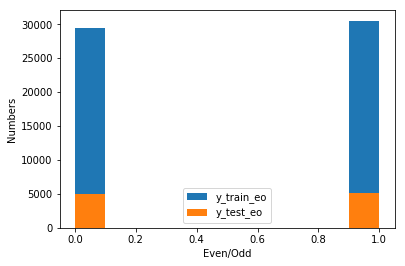

In [14]:
plt.hist(y_train_eo)
plt.hist(y_test_eo)

plt.xlabel('Even/Odd')
plt.ylabel('Numbers')
plt.legend(['y_train_eo','y_test_eo'], loc = 'best')

In [15]:
def draw_y(num):
    plt.imshow(x_train0[num], cmap = 'Greys')
    print(f'This is {y_train0[num]}')
    
interact(draw_y, num = (0,9999))

interactive(children=(IntSlider(value=4999, description='num', max=9999), Output()), _dom_classes=('widget-int…

<function __main__.draw_y(num)>

# 3. 回顧 Sequential

In [16]:
model = Sequential()
model.add(Dense(500, input_dim = 784)) # 每層最多 500 個神經元可用
model.add(Activation('sigmoid'))
model.add(Dense(500))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


In [17]:
784*500+500

392500

## 3.1 另一種使用 Sequential 建立神經網路的方式
#### 觀察 "model.layers"

In [18]:
model.layers

### 相當於 把神經網路一層層放入 keras.layers 這個list中

### 將神經網路打包再放入學習機 (轉移學習 Transfer learning)

In [19]:
first_layer = [Dense(500, input_dim = 784), Activation('sigmoid')]

second_layer = [Dense(500), Activation('sigmoid')]

last_layer = [Dense(10), Activation('softmax')]

In [20]:
first_layer + second_layer + last_layer

In [21]:
model = Sequential(first_layer + second_layer + last_layer)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_4 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_5 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5010      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


## 3.2 轉移學習
#### 例如今天把辨識數字(0~9)換成辨識奇偶數(0/1)，且希望沿用除了最後一層的模型

In [23]:
all_except_but_last_layer = [Dense(500, input_dim = 784),
                             Activation('sigmoid'),
                             Dense(500),
                             Activation('sigmoid')]
last_layer = [Dense(10), Activation("softmax")]

In [24]:
model_num = Sequential(all_except_but_last_layer + last_layer)
model_num.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_7 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5010      
_________________________________________________________________
activation_9 (Activation)    (None, 10)                0         
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_num.load_weights('My_first_NN_weights.h5')

In [26]:
model_num.compile(optimizer='sgd', loss = 'mse', metrics = ['acc'])

In [27]:
score = model_num.evaluate(x_train, y_train_num)
print('loss:', score[0])
print('accuracy:',score[1])

60000/60000 [==============================] - 9s 147us/step
loss: 0.08787583531538645
accuracy: 0.27018333333333333


## 借用這模型的某部分

In [28]:
last_layer_eo = [Dense(2), Activation('softmax')]

In [29]:
model_eo = Sequential(all_except_but_last_layer + last_layer_eo)
model_eo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_7 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1002      
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total params: 644,002
Trainable params: 644,002
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_eo.compile(optimizer='sgd',
                 loss = 'categorical_crossentropy',
                 metrics = ['acc'])

In [31]:
y_train_eo = to_categorical(y_train_eo,2)
y_test_eo = to_categorical(y_test_eo,2)

In [32]:
y_train_eo

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [33]:
y_test_eo

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [34]:
score_eo = model_eo.evaluate(x_train,y_train_eo,batch_size=10000)

60000/60000 [==============================] - 1s 18us/step


In [35]:
print('loss:',score_eo[0])
print('acc:',score[1])

loss: 0.6977813641230265
acc: 0.27018333333333333


In [36]:
model_eo.fit(x_train,y_train_eo)

Epoch 1/1
60000/60000 [==============================] - 16s 271us/step - loss: 0.5226 - acc: 0.7536


In [37]:
model_num.evaluate(x_train, y_train_num)

60000/60000 [==============================] - 6s 105us/step


[0.08637269655863444, 0.29478333333333334]

## 原本模型的權重被改變了，若希望不要動到原模型的權重，可以如此做:

In [38]:
all_except_but_last_layer[0].trainable

True

In [39]:
for layer in all_except_but_last_layer:
    layer.trainable = False

In [40]:
model_eo.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_7 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1002      
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total params: 1,287,002
Trainable params: 644,002
Non-trainable params: 643,000
______________________________________________________________

C:\Users\Andygyr\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## 動到神經網路元件，可以看到總參數 

In [41]:
model_eo.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])
model_eo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_7 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1002      
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total params: 644,002
Trainable params: 1,002
Non-trainable params: 643,000
_________________________________________________________________


### 注意 summary 的 non-trainable params!
##### 1. 重新讀取舊模型權重
##### 2. 定義新模型並凍結舊模型的部分
##### 3. 訓練新模型
##### 4. 回頭看舊模型的 evaluate

## 4.1 Functional API 的使用時機

當神經網路模型為非線性的複雜網路結構，如：

* 多重輸出-多重輸入模型 (Multi-input and multi-output models)
  + 分歧 (branch)
  + 合併 (merge)
* 具重複/循環結構的模型，如: CycleGAN

Sequential 便不足以建構這類複雜結構的神經網路，我們以下介紹 `Model` Fnuctional API 的使用。

在 `Model` 的世界中，所有的神經網路層 (全連接, 卷積, 池化, RNN等) 都將視作函數來定義，因此，我們只需關心函數的輸入和輸出即可。

此外，為了讓神經網路的第一層從不需要輸入 `input_dim`，我們還需引進下面這個函數來代替 `input_dim`。 (此寫法亦可用在 `Sequential`)

In [42]:
from keras.models import Model
from keras.layers import Input

In [43]:
x = Input(shape=(784,))
f_1 = Dense(500, activation = 'sigmoid')
f_2 = Dense(500, activation = 'sigmoid')
f_3 = Dense(10, activation = 'softmax')

In [44]:
h_1 = f_1(x)

In [45]:
print(x)  # 784維的向量

Tensor("input_1:0", shape=(?, 784), dtype=float32)


In [46]:
print(h_1)  #500維的向量

Tensor("dense_11/Sigmoid:0", shape=(?, 500), dtype=float32)


In [47]:
print(f_1)

In [48]:
h_2 = f_2(h_1)
y = f_3(h_2)

 ### 神經網路定義完成，接下來要告訴它輸入是誰
 

In [49]:
model = Model(x,y)

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5010      
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss = 'mse', optimizer=SGD(lr = 0.1), metrics=['accuracy'])

In [52]:
model.load_weights("My_first_NN_weights.h5")

In [53]:
score = model.evaluate(x_train, y_train_num, batch_size=10000)
print('Loss :%f' %score[0])
print("Accuracy: %f" %score[1])

60000/60000 [==============================] - 1s 17us/step
Loss :0.087876
Accuracy: 0.270183


In [54]:
from keras.layers import concatenate, add 

In [55]:
f_3 = Dense(10, activation='softmax')
f_4 = Dense(500, activation='relu') 
z = f_4(h_1)

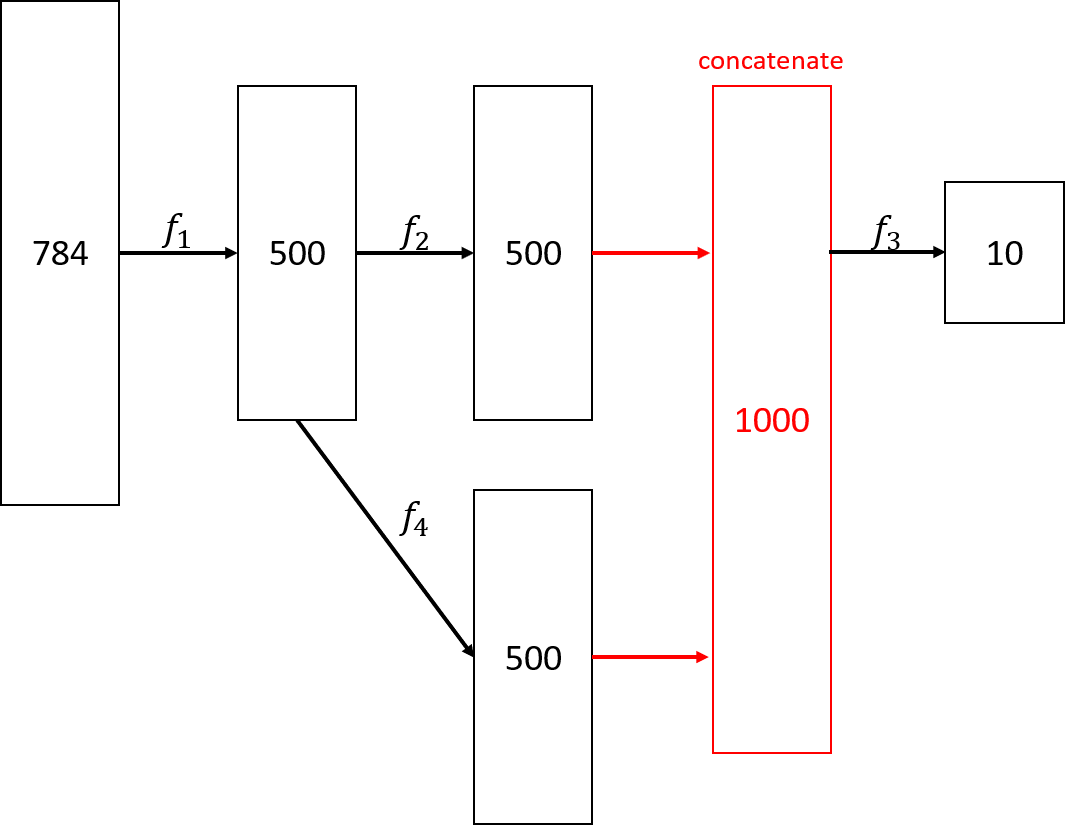

In [56]:
u = concatenate( [h_2,z] ) #用 list 接起來再送進去

In [57]:
y = f_3(u)

In [58]:
model = Model(x,y)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 500)          250500      dense_11[0][0]                   
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 500)          250500      dense_11[0][0]                   
__________________________________________________________________________________________________
concatenat

In [59]:
SGD

keras.optimizers.SGD

In [60]:
model.compile(optimizer=SGD(lr = 0.1), loss = 'mse')

## 5.3 自定義的不具可訓練權重之神經網路層


首先，我們需要引入 `Lambda` 這個函數，透過 `Lambda` 函數，我們可以將 Python 上的 function，包裝成 Keras 上的 layer。

此外，我們需要引進後端所使用的套件 (此處為 TensorFlow)，並使用裡面的運算進行 function 的撰寫。

In [61]:
from keras.layers import Lambda

In [62]:
from keras import backend as K

In [63]:
K.mean

<function keras.backend.tensorflow_backend.mean(x, axis=None, keepdims=False)>

In [64]:
test_array = np.arange(12).reshape(1,2,6)
test_array

array([[[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]]])

In [66]:
# K.mean(test_array)

# Tensorflow 有自定義的類型，因此無法使用numpy

In [70]:
y = K.mean(x)

In [72]:
# model = Model(x,y)   y 需要被 layer、dense 處理過

In [73]:
keras_mean = Lambda(K.mean)

In [75]:
keras_mean  # layer

In [77]:
keras_mean(x)

<tf.Tensor 'lambda_1_1/Mean:0' shape=() dtype=float32>

In [78]:
model = Model(x, keras_mean(x))

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
lambda_1 (Lambda)            ()                        0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [83]:
keras_mean = Lambda(K.mean, output_shape= (1,))
model = Model(x, keras_mean(x))

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 1)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [85]:
x_train[0].shape

(784,)

In [87]:
x_train[:1].shape

(1, 784)

In [88]:
model.predict(x_train[:1])

array([0.13768007], dtype=float32)

In [90]:
x_train[:1].mean()

0.13768007202881152